In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse

# Import data
from tensorflow.examples.tutorials.mnist import input_data

import tensorflow as tf

FLAGS = None

mnist = input_data.read_data_sets('./data/MNIST', one_hot=True)

Extracting ./data/MNIST/train-images-idx3-ubyte.gz
Extracting ./data/MNIST/train-labels-idx1-ubyte.gz
Extracting ./data/MNIST/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST/t10k-labels-idx1-ubyte.gz


//anaconda/envs/tensorflow/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


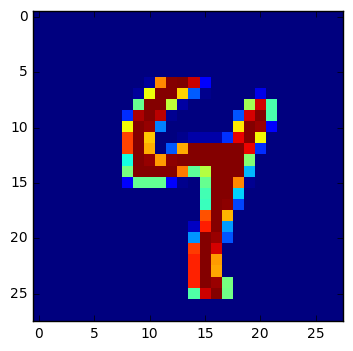

In [2]:
import matplotlib.pyplot as plt
import numpy as np

images, labels = mnist.train.next_batch(5)
plt.imshow(np.reshape(images[2], (28, 28)), interpolation='nearest')
plt.show()


(28, 56)


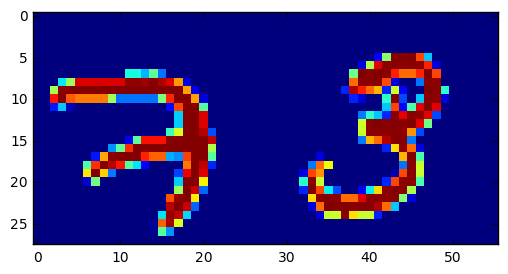

[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]]


In [4]:
from scipy import ndimage, misc

def concat_images(images):
    if images.shape[0] == 1:
        return np.reshape(images, (28, 28))
    return np.concatenate((np.reshape(images[0], (28,28)), concat_images(images[1:])), axis = 1)

def concat_labels(labels):
    if labels.shape[0] == 1:
        return labels
    return np.concatenate((labels[0], concat_labels(labels[1:])), axis = 1)

image = concat_images(images[0:2])
print (image.shape)
image = misc.imresize(image, (28, 2*28))
result_label = np.concatenate((labels[0], labels[1]), axis = 0)
plt.imshow(image, interpolation='nearest')
plt.show()
print (np.reshape(result_label, (2, 10)))

[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


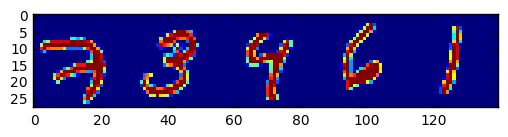

In [5]:
result = concat_images(images[0:5])
print (labels[0:5].flatten())
plt.imshow(result, interpolation='nearest')
plt.show()

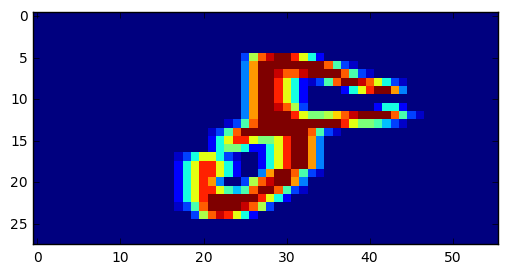

[10  8]


In [15]:
import random
import math
digits = 2
hight = 28
width = 56

blank = np.zeros((28, 28))
blank_label = np.zeros((1, 11))
blank_label[0][10] = 1
blank_label = blank_label.flatten()

def decode_labels(labels):
    result = 0
    for i in range(labels.shape[0]):
        result *= 10
        result += np.ndarray.argmax(labels[i], axis = 0)
    return result

def gen_train_example():
    r = random.randint(1, digits)
    noOfBlanks = digits - r
    images, labels = mnist.train.next_batch(digits-noOfBlanks)
    result_image = concat_images(images)
    result_image = misc.imresize(result_image, (hight, width))
    result_label = np.concatenate((labels, np.zeros((labels.shape[0], 1))), axis = 1)
    result_label = result_label.flatten()
    for _ in range(noOfBlanks):
        result_label = np.concatenate((blank_label, result_label), axis = 0)
    return result_image, result_label

def gen_train_examples(size):
    img = np.ndarray(shape=(size, hight, width))
    lbl = np.ndarray(shape=(size, 11*digits))
    for i in range(size):
        img[i], lbl[i] = gen_train_example()
    return img, lbl

def gen_test_example():
    r = random.randint(1, digits)
    noOfBlanks = digits - r
    images, labels = mnist.test.next_batch(digits-noOfBlanks)
    result_image = concat_images(images)
    result_image = misc.imresize(result_image, (hight, width))
    result_label = np.concatenate((labels, np.zeros((labels.shape[0], 1))), axis = 1)
    result_label = result_label.flatten()
    for _ in range(noOfBlanks):
        result_label = np.concatenate((blank_label, result_label), axis = 0)
    return result_image, result_label

def gen_test_examples(size):
    img = np.ndarray(shape=(size, hight, width))
    lbl = np.ndarray(shape=(size, 11*digits))
    for i in range(size):
        img[i], lbl[i] = gen_test_example()
    return img, lbl

images, labels = gen_train_examples(2)
plt.imshow(images[0], interpolation='nearest')
plt.show()
print (np.argmax(np.reshape(labels[0], (digits, 11)), 1))

In [7]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [47]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse

FLAGS = None
input_image_size = 28*28*digits

learning_rate = tf.placeholder(tf.float32, shape=[])

# Create the model
x = tf.placeholder(tf.float32, [None, hight, width]) 
x_image = tf.reshape(x, [-1, hight, width, 1])

keep_prob = tf.placeholder(tf.float32)

## First Convolutional Layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
  
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)
h_lrn1 = tf.nn.lrn(h_pool1)
  
## Second Convolutional Layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_lrn1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)
h_lrn2 = tf.nn.lrn(h_pool2)

## Densely Connected Layer 1
W_fc1 = weight_variable([hight * width * 4, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_lrn2, [-1, hight * width * 4])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

## Densely Connected Layer 2
W_fc2 = weight_variable([1024, 1024])
b_fc2 = bias_variable([1024])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

## Readout Layer
W_fc3 = weight_variable([1024, 11*digits])
b_fc3 = bias_variable([11*digits])

y_conv = tf.matmul(h_fc2_drop, W_fc3) + b_fc3
y_conv_r = tf.reshape(y_conv, [-1, digits, 11])

y_ = tf.placeholder(tf.float32, [None, 11*digits])
y_r = tf.reshape(y_, [-1, digits, 11])

cross_entropy = tf.reduce_mean(  tf.nn.softmax_cross_entropy_with_logits(y_conv_r[0], y_r[0]) 
                               + tf.nn.softmax_cross_entropy_with_logits(y_conv_r[1], y_r[1]))

train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy)


correct_prediction = tf.equal(tf.argmax(y_conv_r, 2), tf.argmax(y_r, 2))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
for i in range(5001):
  batch_images, batch_labels = gen_train_examples(50)
  lr = 0.00001
  loss = train_step.run(feed_dict={x: batch_images, y_: batch_labels, keep_prob: 1.0, learning_rate: lr})
  if i%100 == 0:
    batch_images, batch_labels = gen_train_examples(200)
    loss, train_accuracy = sess.run([cross_entropy, accuracy], feed_dict={x:batch_images, y_: batch_labels, keep_prob: 1.0, learning_rate: lr})
#    train_accuracy = accuracy.eval(feed_dict={x:batch_images, y_: batch_labels, keep_prob: 1.0})
    print("step %d, training accuracy %g, loss %g"%(i, train_accuracy, loss))
  
test_imgs, test_labels = gen_test_examples(1000)
print("test accuracy %g"%accuracy.eval(feed_dict={
  x: test_imgs, y_: test_labels, keep_prob: 1.0}))

Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x291991f10>> ignored


step 0, training accuracy 0.09, loss 36.8968
step 100, training accuracy 0.2925, loss 10.497
step 200, training accuracy 0.3325, loss 1.90155
step 300, training accuracy 0.335, loss 8.23522
step 400, training accuracy 0.39, loss 6.51378
step 500, training accuracy 0.4225, loss 1.61092
step 600, training accuracy 0.4075, loss 6.29998
step 700, training accuracy 0.45, loss 2.59703
step 800, training accuracy 0.4875, loss 4.44641
step 900, training accuracy 0.4325, loss 4.46668
step 1000, training accuracy 0.4875, loss 2.23849
step 1100, training accuracy 0.5825, loss 2.03229
step 1200, training accuracy 0.5025, loss 3.08046
step 1300, training accuracy 0.5675, loss 3.47987
step 1400, training accuracy 0.625, loss 2.44237
step 1500, training accuracy 0.605, loss 1.95668
step 1600, training accuracy 0.62, loss 3.8457
step 1700, training accuracy 0.625, loss 0.523236
step 1800, training accuracy 0.655, loss 2.14686
step 1900, training accuracy 0.675, loss 2.03694
step 2000, training accurac

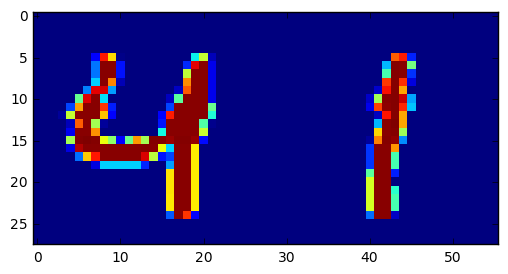

[[  2.73219805e-04   2.75955274e-04   2.12883577e-03   1.72216623e-05
    9.81471002e-01   9.60488617e-03   7.16195427e-06   1.46365771e-03
    3.15125246e-04   4.43182560e-03   1.10887486e-05]
 [  5.29455021e-03   7.06549585e-01   1.67034648e-03   2.60802428e-03
    5.94993355e-03   1.70997933e-01   3.10346968e-02   4.49852236e-02
    2.71496139e-02   3.75835691e-03   1.76499373e-06]]
[4 1]
[4 1]


In [66]:
def decode(output):
    result = ''
    for x in output:
        if x != 10:
            result = result + str(x)
    return result


test_imgs, test_labels = gen_test_examples(1)
plt.imshow(test_imgs[0], interpolation='nearest')
plt.show()
pred = y_conv.eval(feed_dict={x:test_imgs, keep_prob: 1.0})
pred = tf.reshape(pred, (digits, 11))
pred = tf.nn.softmax(pred)
print (pred.eval())
pred = tf.argmax(pred, 1)
print (pred.eval())
print (np.argmax(tf.reshape(test_labels, (digits, 11)).eval(), 1))